<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/HoughwThresholding/Baseline_CNN_and_RF_on_224dpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
from datetime import datetime
import time

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers.normalization import batch_normalization
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split


In [2]:
# Set up folder
SIZE = 224 #Size of the images this model will deal with
IMDIM = 3
Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio
RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything   
ACCURACY_THRESHOLD = 0.9           # Set the desired accuracy threshold
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape
num_classes = 2  # Number of clases for prediction

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/224.zip" -d "/content"

Archive:  /content/drive/My Drive/224.zip
   creating: /content/224/
  inflating: /content/224/6c17ffdf996199dd1ad6b9a973db0857-127-0.jpg  
  inflating: /content/224/543dbc657725f7f189ee5cd6005889bc-100-0.jpg  
  inflating: /content/224/2c62c5c8671549a731e2eb049ca5e31f-103-0.jpg  
  inflating: /content/224/a58a4ca2b656f6463c9b9765495eb97d-127-0.jpg  
  inflating: /content/224/24e053c4e8ec4ebf2fe57e9bbd09626f-79-0.jpg  
  inflating: /content/224/3c8d7a89d58ef4508ded25721a770cfe-119-0.jpg  
  inflating: /content/224/4088772371dffd56986bad40ec63a5cb-265-0.jpg  
  inflating: /content/224/852d5510bf2c1d40db3d614d3f7d34ed-268-0.jpg  
  inflating: /content/224/503cb636a3d2bafd275efd7c4ffc9dc5-209-0.jpg  
  inflating: /content/224/5ed142b6b00e17680e98bba1e18333a4-68-0.jpg  
  inflating: /content/224/3ea01a56492b44f7f28b1fbb76136f84-211-0.jpg  
  inflating: /content/224/80ad3425050e6594e67e913a21f3b609-169-0.jpg  
  inflating: /content/224/03a2163d623d5ff2d4addb0095869d03-94-0.jpg  
  inflating

In [5]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p, f'{SIZE}')

# Read filenames in the folder
image_names = []
labels = []

for file in glob.glob(f'{input_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

X_files = np.array(image_names) #  Array with image nbames
y = np.array(labels)			#  Array with binary labels

print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

# Read the actual files
print("Reading actual images...")
images = []
for file_name in X_files:
    file = os.path.join(input_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images.append(img)

images = np.array(images)

Full dataset: 300 images with bacteria and 3479 without
Reading actual images...


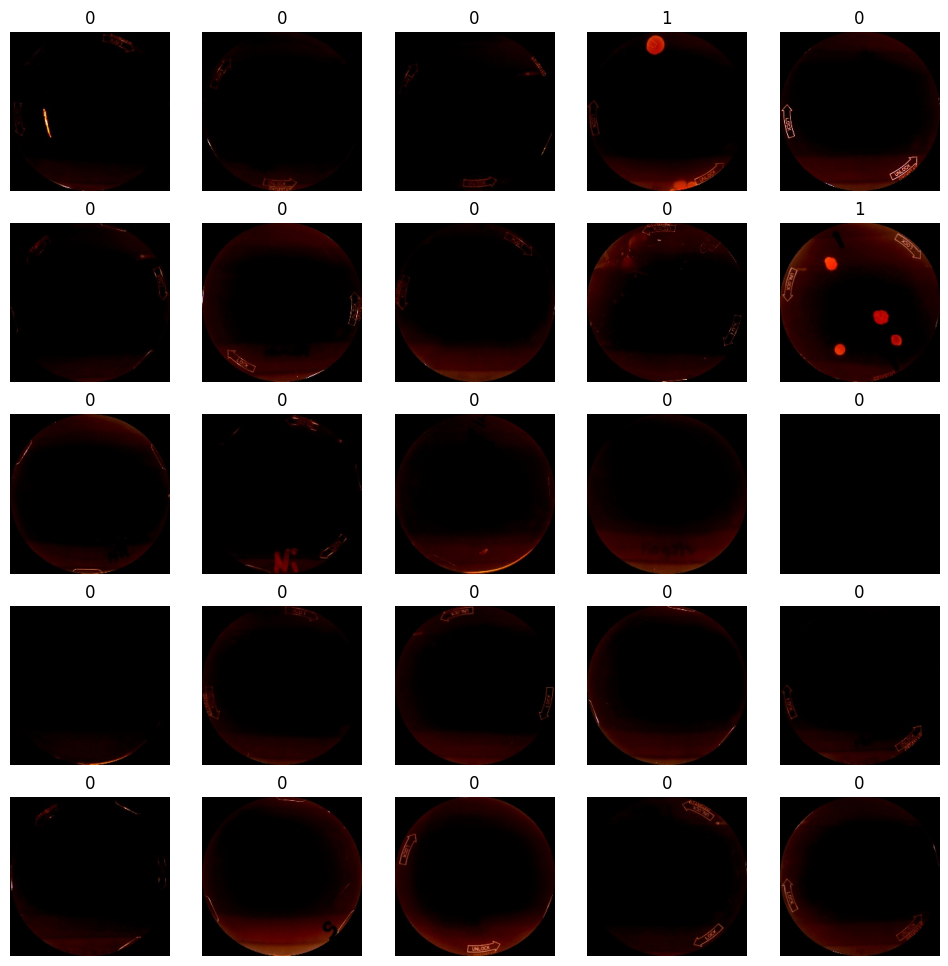

In [6]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    image = images[idx]
    axs[i,j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y[idx])
    axs[i,j].axis('off')

plt.show()

In [7]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def prepare_data(X, y, test_size=TEST_SIZE, random_state=RAND_SEED):
    # On the highly imbalanced dataset I can not rely on the random split between training and val sets
    # Test subset can randomly have too few or too many positive cases
    # Have to select pre-defined number of random images from each class and stack them together
    np.random.seed(RAND_SEED) # For reproducibility


    #  Make two arrays with images: one for positive and one for negative images
    pos_im = [X[i] for i in range(X.shape[0]) if y[i]]
    pos_im = np.array(pos_im)
    neg_im = [X[i] for i in range(X.shape[0]) if not y[i]]
    neg_im = np.array(neg_im)
    num_pos = pos_im.shape[0]
    num_neg = neg_im.shape[0]
    print(f'Full dataset: {num_pos} images with bacteria and {num_neg} without')

    # Select random positive images
    # Make two random indeces for val and train
    idx_pos_val = np.random.choice(np.arange(num_pos), int(num_pos*TEST_SIZE), replace = False)
    idx_pos_train = [i for i in np.arange(num_pos) if i not in idx_pos_val]
    #  Apply this index to the array of image names
    X_val_pos = pos_im[idx_pos_val]
    X_train_pos = pos_im[idx_pos_train]
    y_val_pos = np.ones(len(idx_pos_val))
    y_train_pos = np.ones(len(idx_pos_train))
    #print(f"{X_val_pos.shape[0]}pos selected for val and {X_train_pos.shape[0]} selected for train")
    #print(f"{y_val_pos.shape[0]}pos labels for val and {y_train_pos.shape[0]} pos labels for train")

    # Select random negative images
    # Make two random indeces for val and train
    idx_neg_val = np.random.choice(np.arange(num_neg), int(num_neg*TEST_SIZE), replace = False)
    idx_neg_train = [i for i in np.arange(num_neg) if i not in idx_neg_val]
    #  Apply this index to the array of image names
    X_val_neg = neg_im[idx_neg_val]
    X_train_neg = neg_im[idx_neg_train]
    y_val_neg = np.zeros(len(idx_neg_val))
    y_train_neg = np.zeros(len(idx_neg_train))
    #print(f"{X_val_neg.shape[0]}neg selected for val and {X_train_neg.shape[0]} selected for train")
    #print(f"{y_val_neg.shape[0]}neg labels for val and {y_train_neg.shape[0]} neg labels for train")

    # Stack two classes together
    X_val = np.concatenate((X_val_neg, X_val_pos), axis = 0)
    y_val = np.concatenate((y_val_neg, y_val_pos), axis = 0)
    X_train = np.concatenate((X_train_neg, X_train_pos), axis = 0)
    y_train = np.concatenate((y_train_neg, y_train_pos), axis = 0)

    # Shuffle validation
    print("Suffling validation dataset ....")
    num_val = X_val.shape[0]
    indices = np.arange(num_val)
    shuffled_indices = np.random.permutation(indices)
    X_val = X_val[shuffled_indices]
    y_val = y_val[shuffled_indices]
    print(f"{X_val.shape} - {y_val.shape}")

    # Shuffle training
    print("Suffling trainig dataset ....")
    num_train = X_train.shape[0]
    indices = np.arange(num_train)
    shuffled_indices = np.random.permutation(indices)
    X_train = X_train[shuffled_indices]
    y_train = y_train[shuffled_indices]

    #Conver to np array and normalize
    X_train = np.array(X_train).astype(np.float32)/255 # Shuffled dataset
    X_val = np.array(X_val).astype(np.float32)/255 # Shuffled dataset
    y_train = np.array(y_train).astype(int)
    y_val = np.array(y_val).astype(int)

    # One-hot encode the labels
    num_classes = max(np.max(y_train), np.max(y_val)) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    print(f"Vlaidation X: {X_val.shape}; y: {y_val.shape}")
    print(f"Training X: {X_train.shape}; y: {y_train.shape}")

    return X_train, X_val, y_train, y_val

def evaluate_model(model, history, X_val, y_val, plot_target = False):
    # Evaluate the model
    y_true = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)

    y_pred_dense = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    # Convergence time
    convergence = history.history['loss'][-1]

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    #Plot precision and recall
    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred[:,1], name="CNN Model")
    _ = display.ax_.set_title("Precision-Recall curve")
    _ = display.ax_.set_xlim(0,1)
    _ = display.ax_.set_ylim(0,1)
    _ = display.ax_.spines['top'].set_visible(False)
    _ = display.ax_.spines['right'].set_visible(False)
    if plot_target:
      _ = display.ax_.fill_between([0.99,1], [0.3,0.3], [1,1], facecolor = 'green', alpha=.5)

    return f1, accuracy, convergence, recall

def evaluate_RF_model(model, X_val, y_val):
    y_true = np.argmax(y_val, axis=1)
    y_pred_dense = np.argmax(model.predict(X_val), axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    return f1, accuracy, recall


In [8]:
# prepare data
X_train, X_val, y_train, y_val = prepare_data(images, y)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Full dataset: 300 images with bacteria and 3479 without
Suffling validation dataset ....
(1133, 224, 224, 3) - (1133,)
Suffling trainig dataset ....
Vlaidation X: (1133, 224, 224, 3); y: (1133, 2)
Training X: (2646, 224, 224, 3); y: (2646, 2)


In [9]:
def make_conv_layers(input_shape):

    conv_layers = Sequential()

    # Zero'th convolutional layer
    conv_layers.add(Conv2D(16, (7, 7), activation='relu', input_shape=input_shape))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # First convolutional layer
    conv_layers.add(Conv2D(32, (9, 9), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    conv_layers.add(Conv2D(64, (11, 11), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    conv_layers.add(Conv2D(128, (13, 13), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    conv_layers.add(Flatten())

    return conv_layers

def create_cnn_model(conv_layers, num_classes):
    conv_layers.add(Dense(512, activation='relu'))
    conv_layers.add(Dropout(0.5))
    conv_layers.add(Dense(num_classes, activation='softmax'))
    return conv_layers

In [10]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

# Define the CNN model
# Make it so that we would have a pointer to convolutional layers
conv_layers = make_conv_layers(INPUT_SHAPE)
cnn_model = create_cnn_model(conv_layers, num_classes)

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7feae0261a60>>

In [11]:
# Train the model with the early stopping callback
start_time = time.time()
cnn_history = cnn_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[early_stopping])
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

Epoch 1/100
83/83 [==============================] - 23s 91ms/step - loss: 0.5886 - accuracy: 0.9312 - val_loss: 1.5521 - val_accuracy: 0.9206
Epoch 2/100
83/83 [==============================] - 5s 59ms/step - loss: 0.3416 - accuracy: 0.9467 - val_loss: 1.4479 - val_accuracy: 0.9206
Epoch 3/100
83/83 [==============================] - 5s 60ms/step - loss: 0.2539 - accuracy: 0.9554 - val_loss: 1.2667 - val_accuracy: 0.9206
Epoch 4/100
83/83 [==============================] - 5s 59ms/step - loss: 0.1697 - accuracy: 0.9701 - val_loss: 1.5925 - val_accuracy: 0.9206
Epoch 5/100
83/83 [==============================] - 5s 59ms/step - loss: 0.1056 - accuracy: 0.9769 - val_loss: 2.6323 - val_accuracy: 0.9206
Epoch 6/100
83/83 [==============================] - 5s 59ms/step - loss: 0.1412 - accuracy: 0.9724 - val_loss: 0.4505 - val_accuracy: 0.9444
Epoch 7/100
83/83 [==============================] - 5s 60ms/step - loss: 0.1375 - accuracy: 0.9705 - val_loss: 1.1965 - val_accuracy: 0.9426
Epoch

In [17]:
# Set up folder, unless it is already set up
now = datetime.now() # current date and time

date_time = now.strftime("%m-%d-%Y-%H-%M")
p = os.path.abspath('.')
model_dir = os.path.join(p, "drive", "MyDrive", f'baseline_CNN_on_{SIZE}dpi')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print(f"{model_dir} created")
else:
    print(f"{model_dir} already exists")
    model_dir = model_dir+date_time

cnn_model.save(model_dir)


/content/drive/MyDrive/baseline_CNN_on_224dpi already exists


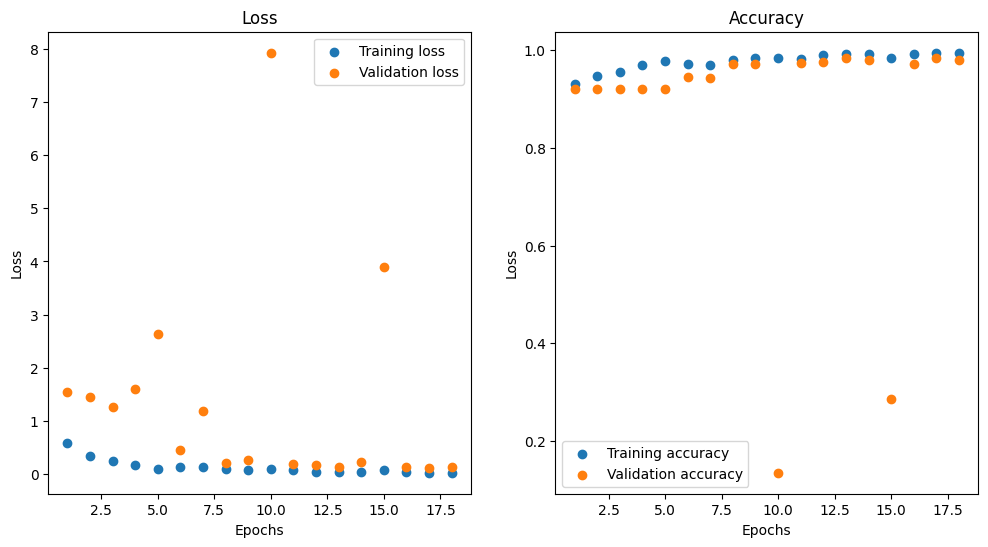

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].set_title('Loss')
axs[0].scatter(epochs, loss, label = 'Training loss')
axs[0].scatter(epochs, val_loss, label = 'Validation loss')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']
axs[1].set_title('Accuracy')
axs[1].scatter(epochs, accuracy, label = 'Training accuracy')
axs[1].scatter(epochs, val_accuracy, label = 'Validation accuracy')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')


plt.show()

36/36 [==============================] - 1s 19ms/step
F1 score: 98.3%, accuracy: 98.3%, recall 82.2%


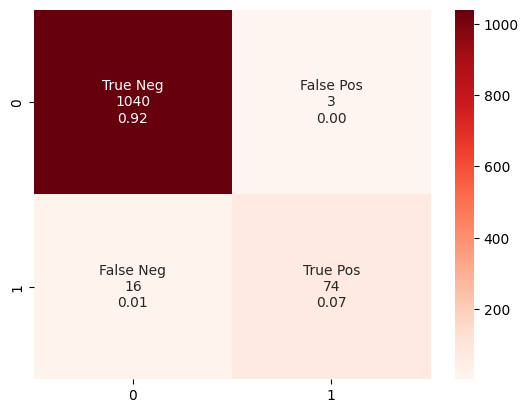

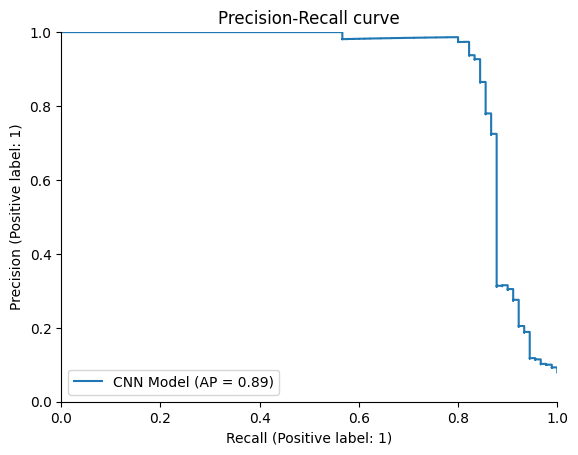

In [19]:

# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(cnn_model, cnn_history, X_val, y_val)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")

In [20]:
#  Now, let us use features from convolutional network for RF
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

#Make a forward pass through convolutional layers
#This will be a set of features to train RF
X_for_RF = conv_layers.predict(X_train) 

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

83/83 [==============================] - 2s 18ms/step


RandomForestClassifier(n_estimators=50, random_state=42)

36/36 [==============================] - 1s 19ms/step
F1 score: 0.9767
Accuracy: 0.9771
Recall: 0.8222



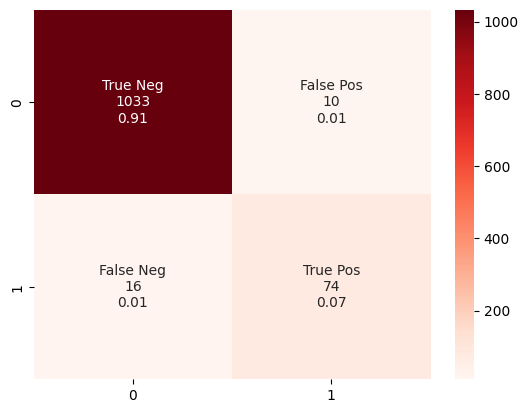

In [21]:
# Evaluate RF model
#Send test data through same feature extractor process
X_test_feature = conv_layers.predict(X_val)

f1, accuracy, recall = evaluate_RF_model(RF_model, X_test_feature, y_val)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"")

36/36 [==============================] - 1s 22ms/step


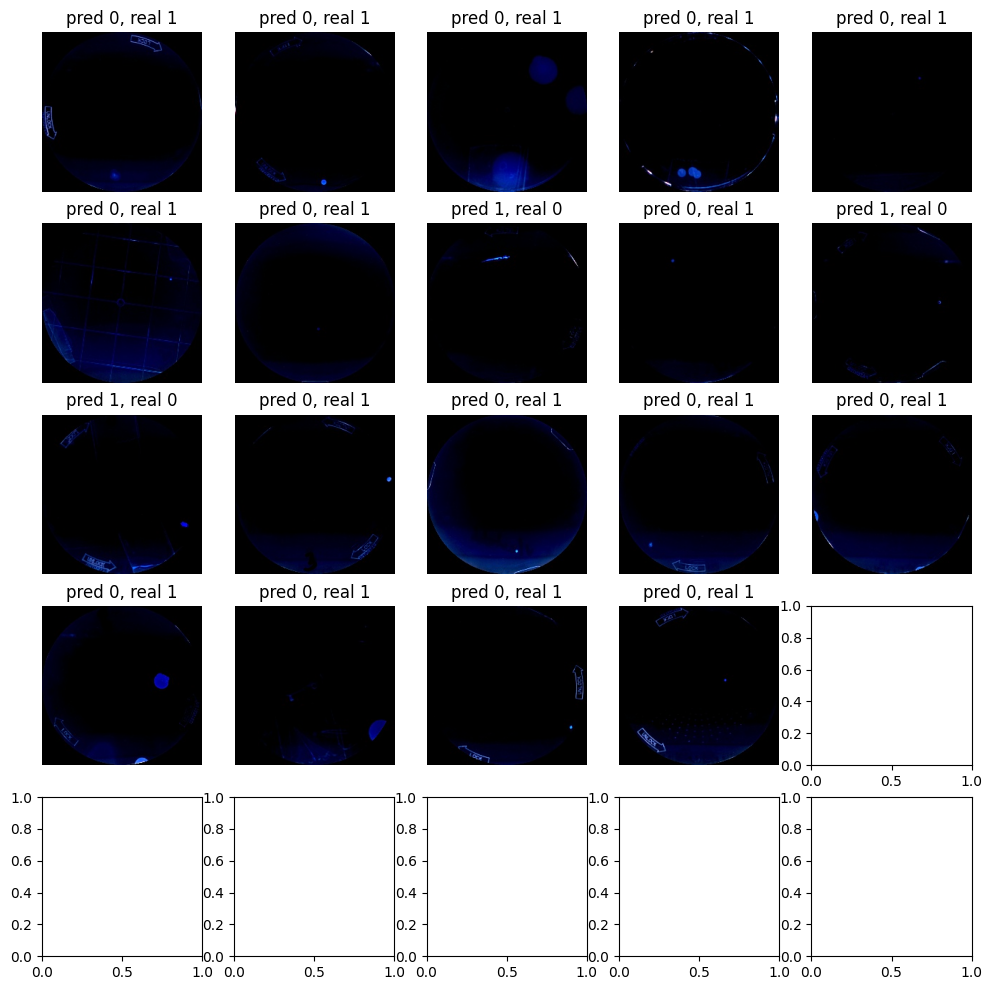

In [22]:
# Visualize 25 mistakes
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(cnn_model.predict(X_val), axis=1)

error_idx = [  i for i, rslt in enumerate(y_true) if (rslt != y_pred[i])  ]


fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    if (5*i+j) < len(error_idx):
        idx = error_idx[5*i+j]
        axs[i,j].imshow(X_val[idx])
        axs[i,j].set_title(f'pred {int(y_pred[idx])}, real {int(y_true[idx])}')
        axs[i,j].axis('off')

plt.show()